In [117]:
#Список библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier

# Задание №1

Данная задача относится к бинарной классификации, так как целевая переменная (Target) имеет два возможных значения:

1 — заемщик имел просрочку платежа на 90 дней или хуже ("Будет испытывать финансовые трудности")

0 — заемщик не имел таких просрочек ("Не будет испытывать финансовые трудности")

Предварительно выбрана метрика AUC потому, что она устойчива к дисбалансу классов и хорошо показывает способность модели отделять один класс от другого, независимо от порога.


# Задание №2

## Исследование данных

In [122]:
#Загрузка датасета

df_train = pd.read_excel('train.xlsx')

print("Train data:", df_train.shape)

KeyboardInterrupt: 

In [5]:
df_train

,Unnamed: 0,Age,FamilySize,PastDueLess_60,PastDue60_90,PastDue90_More,DebtRatio,MonthlyIncome,TotalBalanceDivideCreditLimits,OpenLoans,RealEstateLoans,Target
0,0,56,1.0,1,0,0,0.060571859,5315.0,0.498037,9,0,0
1,1,38,1.0,0,0,0,0.176964607,3333.0,0.060600,5,0,0
2,2,42,2.0,1,0,0,0.412141333,8433.0,0.675398,8,1,0
3,3,34,1.0,2,0,0,0.341436766,3660.0,0.630550,10,0,0
4,4,102,1.0,0,0,0,0.273844353,3417.0,0.109642,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99996,99996,83,0.0,1,0,0,0.0,NaN,1.000000,4,0,0
99997,99997,65,0.0,0,0,0,1373.0,NaN,0.084077,4,1,0
99998,99998,39,4.0,0,0,0,3200.0,NaN,0.509142,20,2,0
99999,99999,58,2.0,0,0,0,0.277908721,14000.0,0.120541,13,2,1


Сразу можно заметить пропуски в данных о размере семьи (FamilySize), о доходе (MontlyIncome)

In [7]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      100001 non-null  int64  
 1   Age                             100001 non-null  int64  
 2   FamilySize                      97329 non-null   float64
 3   PastDueLess_60                  100001 non-null  int64  
 4   PastDue60_90                    100001 non-null  int64  
 5   PastDue90_More                  100001 non-null  int64  
 6   DebtRatio                       100001 non-null  object 
 7   MonthlyIncome                   80251 non-null   float64
 8   TotalBalanceDivideCreditLimits  100001 non-null  float64
 9   OpenLoans                       100001 non-null  int64  
 10  RealEstateLoans                 100001 non-null  int64  
 11  Target                          100001 non-null  int64  
dtypes: float64(3), i

In [8]:
#Уникальные значения
df_train.nunique()

,0
Unnamed: 0,100001
Age,85
FamilySize,13
PastDueLess_60,15
PastDue60_90,13
PastDue90_More,18
DebtRatio,78966
MonthlyIncome,11897
TotalBalanceDivideCreditLimits,84410
OpenLoans,57


Можно так же посмотреть описательную статистику и заметить в некоторых столбцах выбросы,например, максимальный возраст 109

In [9]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,100001.0,50000.000000,28867.946472,0.0,25000.000000,50000.00000,75000.000000,100000.0
Age,100001.0,52.272627,14.765124,21.0,41.000000,52.00000,63.000000,109.0
FamilySize,97329.0,0.760215,1.116240,0.0,0.000000,0.00000,1.000000,20.0
PastDueLess_60,100001.0,0.432916,4.300689,0.0,0.000000,0.00000,0.000000,98.0
PastDue60_90,100001.0,0.249808,4.264301,0.0,0.000000,0.00000,0.000000,98.0
PastDue90_More,100001.0,0.275807,4.277969,0.0,0.000000,0.00000,0.000000,98.0
MonthlyIncome,80251.0,6690.900973,16477.313134,0.0,3400.000000,5398.00000,8250.000000,3008750.0
TotalBalanceDivideCreditLimits,100001.0,6.197871,274.703054,0.0,0.030364,0.15458,0.562878,50708.0
OpenLoans,100001.0,8.442306,5.137405,0.0,5.000000,8.00000,11.000000,58.0
RealEstateLoans,100001.0,1.018020,1.131855,0.0,0.000000,1.00000,2.000000,54.0


## Очистка данных

In [10]:
#Удаление ненужного столбца
df_train.drop(columns= ['Unnamed: 0'], inplace = True)

In [11]:
#Проверка типов данных
print(df_train.dtypes)

Age                                 int64
FamilySize                        float64
PastDueLess_60                      int64
PastDue60_90                        int64
PastDue90_More                      int64
DebtRatio                          object
MonthlyIncome                     float64
TotalBalanceDivideCreditLimits    float64
OpenLoans                           int64
RealEstateLoans                     int64
Target                              int64
dtype: object


In [12]:
#Удаление дубликатов
df_train.duplicated().sum()
df_train.drop_duplicates(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99694 entries, 0 to 100000
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             99694 non-null  int64  
 1   FamilySize                      97069 non-null  float64
 2   PastDueLess_60                  99694 non-null  int64  
 3   PastDue60_90                    99694 non-null  int64  
 4   PastDue90_More                  99694 non-null  int64  
 5   DebtRatio                       99694 non-null  object 
 6   MonthlyIncome                   80209 non-null  float64
 7   TotalBalanceDivideCreditLimits  99694 non-null  float64
 8   OpenLoans                       99694 non-null  int64  
 9   RealEstateLoans                 99694 non-null  int64  
 10  Target                          99694 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 9.1+ MB


In [13]:
#Количество и процент пропусков
train_missing = pd.DataFrame({'Количество пропусков': df_train.isnull().sum(), 'Процент пропусков': (df_train.isnull().sum()/df_train.shape[0])*100})
train_missing

,Количество пропусков,Процент пропусков
Age,0,0.000000
FamilySize,2625,2.633057
PastDueLess_60,0,0.000000
PastDue60_90,0,0.000000
PastDue90_More,0,0.000000
DebtRatio,0,0.000000
MonthlyIncome,19485,19.544807
TotalBalanceDivideCreditLimits,0,0.000000
OpenLoans,0,0.000000
RealEstateLoans,0,0.000000


Так как у нас пропуски в количественных признаках, то можно использовать KNN для заполения пропусков

In [14]:
imputer = KNNImputer(n_neighbors=5)

In [15]:
columns_to_impute = ['MonthlyIncome', 'FamilySize']
df_train[columns_to_impute] = imputer.fit_transform(df_train[columns_to_impute])


Как видно, все пропуски заполнены

In [16]:
df_train.isnull().sum()

,0
Age,0
FamilySize,0
PastDueLess_60,0
PastDue60_90,0
PastDue90_More,0
DebtRatio,0
MonthlyIncome,0
TotalBalanceDivideCreditLimits,0
OpenLoans,0
RealEstateLoans,0


До заполения пропусков

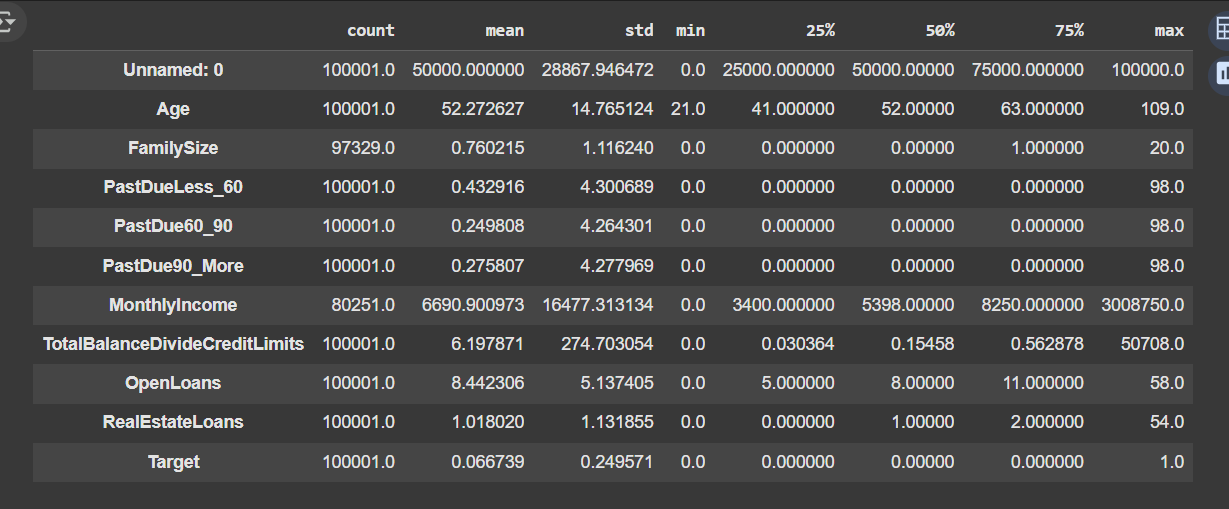

После

In [17]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,99694.0,52.279485,14.727672,21.0,41.000000,52.000000,63.000000,109.0
FamilySize,99694.0,0.762252,1.102235,0.0,0.000000,0.000000,1.000000,20.0
PastDueLess_60,99694.0,0.410657,4.032391,0.0,0.000000,0.000000,0.000000,98.0
PastDue60_90,99694.0,0.226985,3.992403,0.0,0.000000,0.000000,0.000000,98.0
PastDue90_More,99694.0,0.253004,4.007187,0.0,0.000000,0.000000,0.000000,98.0
MonthlyIncome,99694.0,6595.477643,14788.968834,0.0,3897.500000,5764.200000,7601.750000,3008750.0
TotalBalanceDivideCreditLimits,99694.0,6.215523,275.125511,0.0,0.030586,0.154644,0.560843,50708.0
OpenLoans,99694.0,8.463238,5.130596,0.0,5.000000,8.000000,11.000000,58.0
RealEstateLoans,99694.0,1.021155,1.132183,0.0,0.000000,1.000000,2.000000,54.0
Target,99694.0,0.066855,0.249771,0.0,0.000000,0.000000,0.000000,1.0


# Задание №3

## Разведовательный анализ

Распределение Age(Возраста) близко к нормальному, а распределение OpenLoans(количество открытых кредитов и кредитных линий) похоже на хи-квадрат распределение

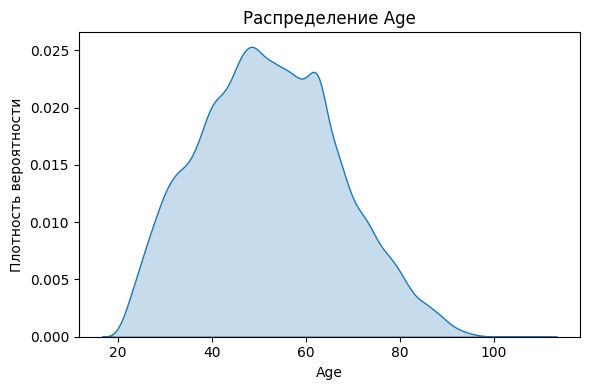

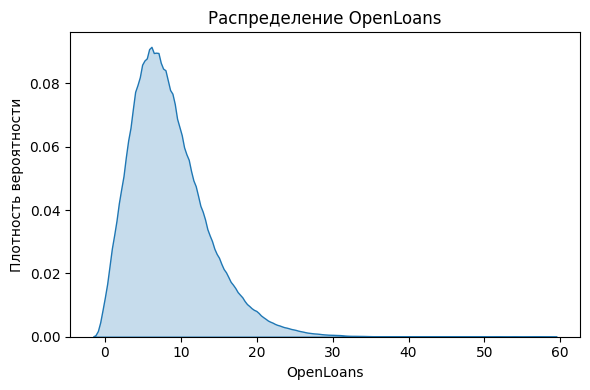

In [18]:
# List of numerical columns
numerical_columns = df_train[['Age', 'OpenLoans']]

# Create histogram plots for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df_train, x=col, fill=True)
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Плотность вероятности')
    plt.tight_layout()
    plt.show()

Распределение по возрасту: Средний возраст заемщиков в наборе данных составляет приблизительно 52 года. Возрастной диапазон варьируется от минимального значения в 0 лет (что может указывать на ошибочные данные) до максимального значения в 109 лет

Количество открытых кредитных линий и займов: Переменная "OpenLoans" имеет среднее значение приблизительно 8.5, что указывает на то, что в среднем заемщики имеют около 8-9 открытых кредитных линий и займов.

Число иждивенцев: Переменная "FamilySize" имеет среднее значение, равное приблизительно 0.76, что указывает на то, что в среднем у заемщиков менее одного иждивенца. Также имеется значительный выброс, равный 20

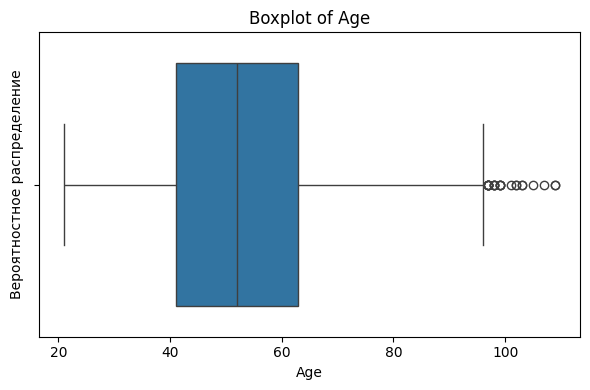

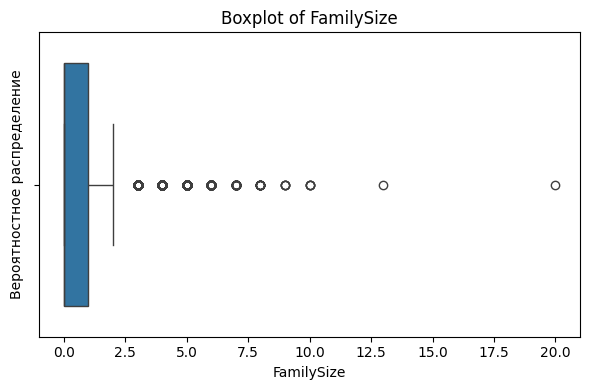

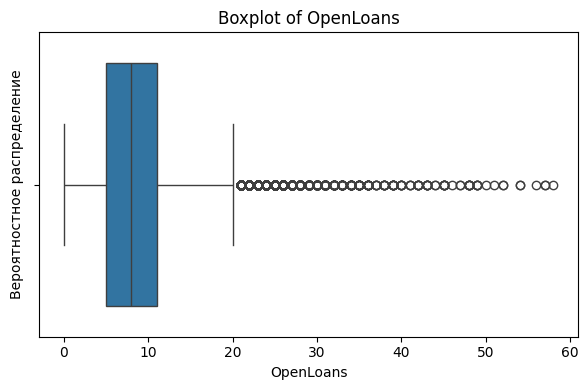

In [19]:
# Boxplot
numerical_columns = ['Age', 'FamilySize', 'OpenLoans']

for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_train, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Вероятностное распределение')
    plt.tight_layout()
    plt.show()

По гистограмме видно, что у нас дисбаланс классов

In [20]:
import plotly.express as px

fig = px.histogram(df_train,
                   x="Target",
                   title="Распределение целевой переменной",
                   color="Target",
                   labels={"count": "Количество"})

fig.update_layout(
    bargap=0.2,
    title_x=0.5,
    title_font=dict(size=20),
    xaxis_title="Целевая переменная",
    yaxis_title="Количество"
)

fig.show()

Общий показатель заемщиков с меткой 1 в наборе данных

In [21]:
# Доля заемщиков, которые просрочили на 90 дней и хуже
total_borrowers = len(df_train)
default_borrowers = len(df_train[df_train['Target'] == 1])
default_rate = (default_borrowers / total_borrowers) * 100
print(f"Процентная доля таргета меткой 1: {default_rate:.2f}%")

Процентная доля таргета меткой 1: 6.69%


In [22]:
defaulted = df_train['Target'].value_counts()
defaulted

,count
Target,
0,93029
1,6665


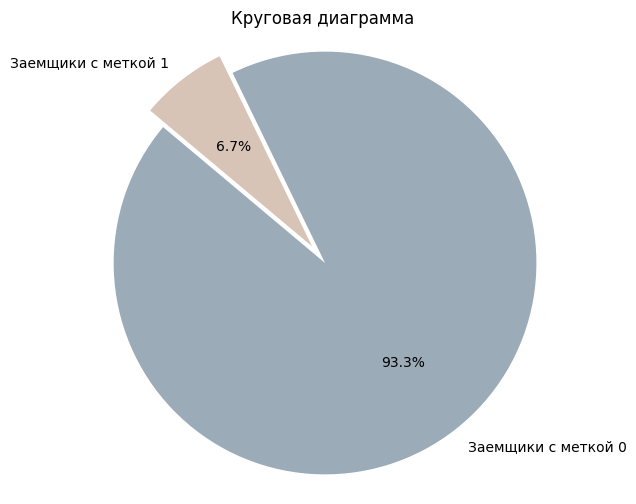

In [23]:
labels = ['Заемщики с меткой 0', 'Заемщики с меткой 1']
sizes = [100 - default_rate, default_rate]
explode = (0, 0.1)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels,colors=['#9BABB8','#D8C4B6'], autopct='%1.1f%%' , startangle=140)
plt.title('Круговая диаграмма ')
plt.axis('equal')

plt.show()

Таблица, где указаны возрастные группы и их количество

In [24]:
age_bins = [20, 30, 40, 50, 60, 70, 80, 90, 100,110]

df_train['age_group'] = pd.cut(df_train['Age'], bins=age_bins)

defaulted_borrowers = df_train[df_train['Target'] == 1]
defaulted_borrowers['age_group'] = defaulted_borrowers['age_group'].astype(str)

age_range_counts = defaulted_borrowers['age_group'].value_counts().reset_index()
age_range_counts.columns = ['Age Range', 'Count']
age_range_counts

<ipython-input-24-75843e85a9a4>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Age Range,Count
0,"(40, 50]",1942
1,"(30, 40]",1586
2,"(50, 60]",1415
3,"(20, 30]",826
4,"(60, 70]",636
5,"(70, 80]",195
6,"(80, 90]",61
7,"(90, 100]",4


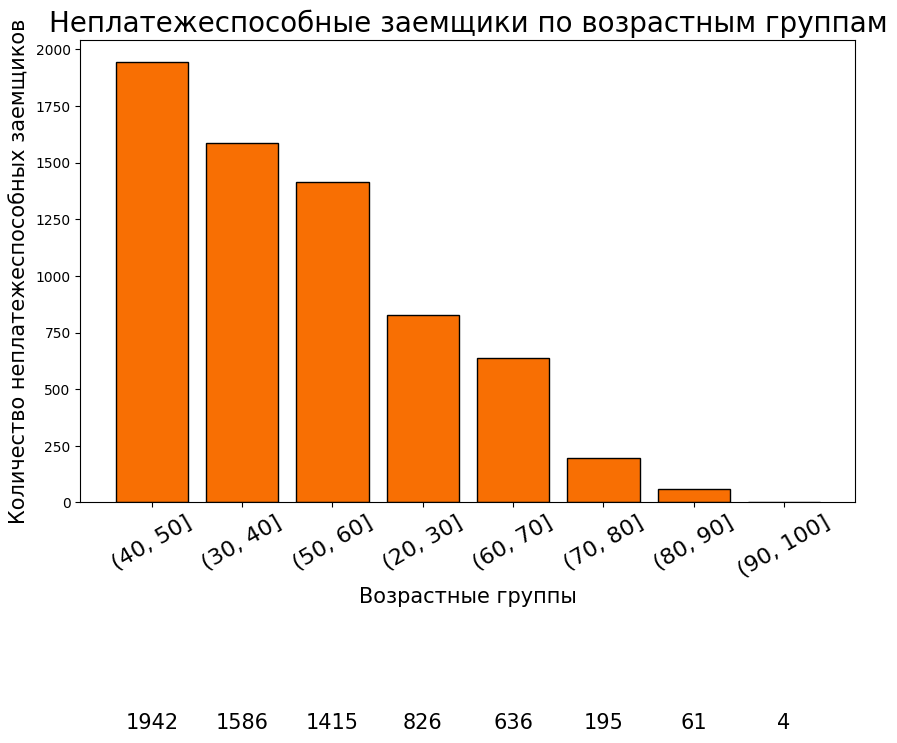

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(age_range_counts['Age Range'], age_range_counts['Count'],color='#F86F03',edgecolor="k",linewidth=1)
plt.xlabel('Возрастные группы',fontsize=15)
plt.ylabel('Количество неплатежеспособных заемщиков',fontsize=15)
plt.title('Неплатежеспособные заемщики по возрастным группам',fontsize=20)
plt.xticks(fontsize=16,rotation=30)
for k,v in age_range_counts['Count'].items():
    plt.text(k,-1000, str(v), fontsize=15,color='k', horizontalalignment='center')
plt.show()

Самое большое количество неплатежеспособных заемщиков в возрасте 40 - 50, возможно, потому что заемщиков возрасте 40-50 больше всего в датасете

Проверим связь между возрастной группой и долей неплатежеспособных заемщиков

Нулевая гипотеза (H₀): Возрастная группа не связана со способностью платить (Target)

Альтернативная гипотеза (H₁): Возрастная группа влияет на платежеспособность

In [26]:
contingency_table = pd.crosstab(df_train['age_group'], df_train['Target'])
print(contingency_table)

Target          0     1
age_group              
(20, 30]     6262   826
(30, 40]    14587  1586
(40, 50]    21466  1942
(50, 60]    21780  1415
(60, 70]    17542   636
(70, 80]     8208   195
(80, 90]     2867    61
(90, 100]     308     4
(100, 110]      9     0


In [27]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Хи-квадрат статистика: {chi2:.4f}")
print(f"P-value: {p:.7f}")

Хи-квадрат статистика: 1310.2131
P-value: 0.0000000


p_value < 0.05 => возраст влияет на платежеспособность заемщика

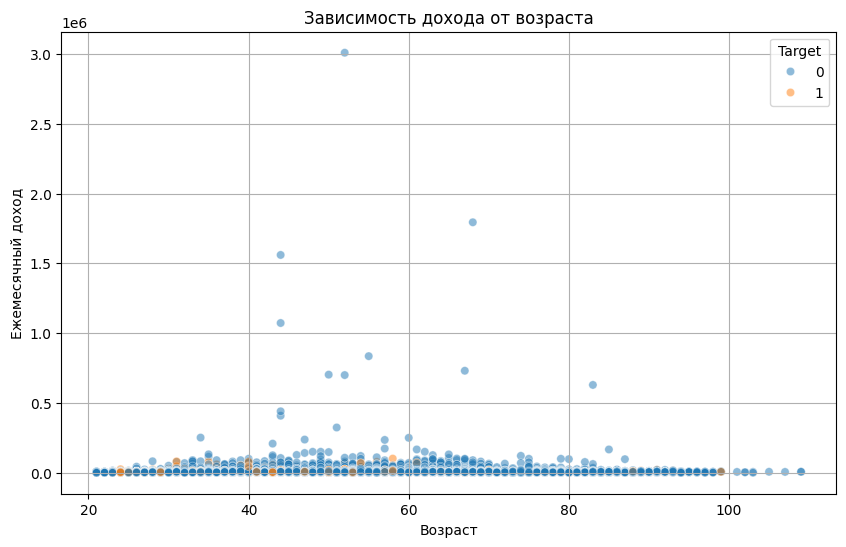

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='Age', y='MonthlyIncome', hue='Target', alpha=0.5)
plt.title('Зависимость дохода от возраста')
plt.xlabel('Возраст')
plt.ylabel('Ежемесячный доход')
plt.legend(title='Target')
plt.grid(True)
plt.show()

По графику видно, что точки сконцентрированы у оси х, возможно, потому что есть выбросы, и масштаб так настраивается

Возможно, у нас пропуски не совсем корректно заполнены.

Посмотрим количество заеммщиков, у кого доход или размер семьи меньше 1

In [29]:
# Установим "почти ноль" как, например, меньше 1
threshold = 1

# Для дохода
zero_income_count = (df_train['MonthlyIncome'] < threshold).sum()

# Для размера семьи
zero_family_count = (df_train['FamilySize'] < threshold).sum()

print(f"Количество доходов < {threshold}: {zero_income_count}")
print(f"Количество размеров семьи < {threshold}: {zero_family_count}")


Количество доходов < 1: 1086
Количество размеров семьи < 1: 60104


Много заемщиков, у кого доход или размер семьи < 1. В будущем посмотрим, на зависимость без выбросов

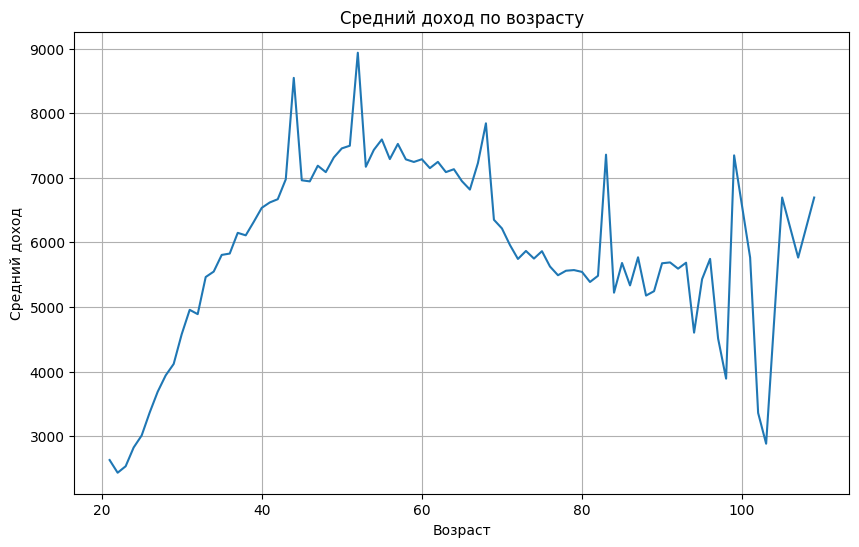

In [30]:
age_income_avg = df_train.groupby('Age')['MonthlyIncome'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=age_income_avg, x='Age', y='MonthlyIncome')
plt.title('Средний доход по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Средний доход')
plt.grid(True)
plt.show()


График показывает, что доход растет с увеличением возраста, потом падает

Неплатежеспособные заемщики в зависимости от дохода. Интуитивно, можно сказать у неплатежеспособных заемщиков (с меткой 1) должен быть низкий доход

In [31]:
income_bins = [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 25000, 30000, 35000, 40000, 50000]
income_labels = ['0-2000', '2000-4000', '4000-6000', '6000-8000', '8000-10000', '10000-12000', '12000-14000',
                 '14000-16000', '16000-18000', '18000-20000', '20000-25000', '25000-30000', '30000-35000',
                 '35000-40000', '40000-50000']

df_train['income_group'] = pd.cut(df_train['MonthlyIncome'], bins=income_bins, labels=income_labels)
defaulted_borrowers = df_train[df_train['Target'] == 1]

income_range_counts = defaulted_borrowers['income_group'].value_counts().reset_index()
income_range_counts.columns = ['Income Range', 'Count']
income_range_counts

,Income Range,Count
0,4000-6000,2217
1,2000-4000,1748
2,6000-8000,1073
3,0-2000,627
4,8000-10000,418
5,10000-12000,208
6,12000-14000,110
7,14000-16000,73
8,16000-18000,43
9,20000-25000,31


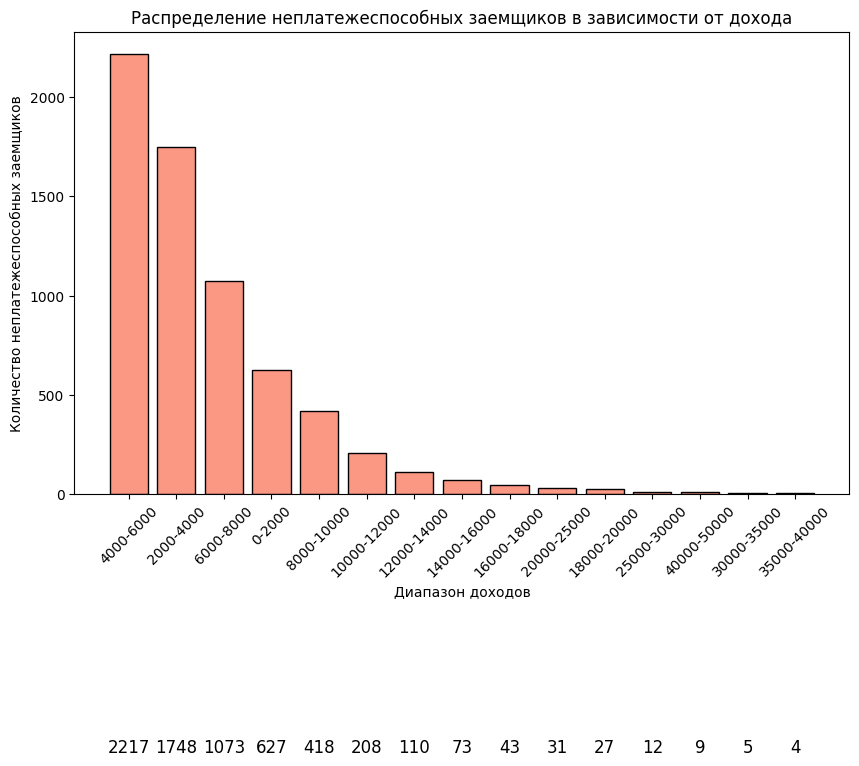

In [32]:
plt.figure(figsize=(10, 6))
plt.bar(income_range_counts['Income Range'], income_range_counts['Count'],color='#FA9884',edgecolor='k')
plt.xlabel('Диапазон доходов')
plt.ylabel('Количество неплатежеспособных заемщиков')
plt.title('Распределение неплатежеспособных заемщиков в зависимости от дохода')
plt.xticks(rotation=45)
for k,v in income_range_counts['Count'].items():
    plt.text(k,-1300, str(v), fontsize=12,color='k', horizontalalignment='center')
plt.show()

По столбчатой диаграмме видно, что чем выше доход, тем ниже число заемщиков. Однако неплатежеспособных заемщиков с доходом 4000-6000 больше, чем с доходом 2000-4000

Проведем статистический тест, чтобы проверить действительно ли средний доход у неплатежеспособных заемщиков ниже, чем у платежеспособных.

Нулевая гипотеза (H0): Средний доход у неплатежеспособных и платежеспособных заемщиков одинаков

Альтернативная гипотеза (H1): Средний доход у неплатежеспособных заемщиков ниже, чем у платежеспособных



In [33]:
# Делим выборки по метке
income_0 = df_train[df_train['Target'] == 0]['MonthlyIncome']  # платежеспособные
income_1 = df_train[df_train['Target'] == 1]['MonthlyIncome']  # неплатежеспособные

stat, p_value = mannwhitneyu(income_1, income_0, alternative='less')

print(f"U-статистика: {stat}")
print(f"P-value: {p_value}")


U-статистика: 263750315.0
P-value: 6.233369414868919e-93


p_value < 0.05 отсюда следует, что отвергаем H0 => доход у неплатежеспособных действительно ниже

Построим корреляционную матрицу

In [34]:
# Преобразуем в float
df_train['DebtRatio'] = pd.to_numeric(df_train['DebtRatio'], errors='coerce').fillna(0).astype(float)


In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99694 entries, 0 to 100000
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Age                             99694 non-null  int64   
 1   FamilySize                      99694 non-null  float64 
 2   PastDueLess_60                  99694 non-null  int64   
 3   PastDue60_90                    99694 non-null  int64   
 4   PastDue90_More                  99694 non-null  int64   
 5   DebtRatio                       99694 non-null  float64 
 6   MonthlyIncome                   99694 non-null  float64 
 7   TotalBalanceDivideCreditLimits  99694 non-null  float64 
 8   OpenLoans                       99694 non-null  int64   
 9   RealEstateLoans                 99694 non-null  int64   
 10  Target                          99694 non-null  int64   
 11  age_group                       99694 non-null  category
 12  income_group          

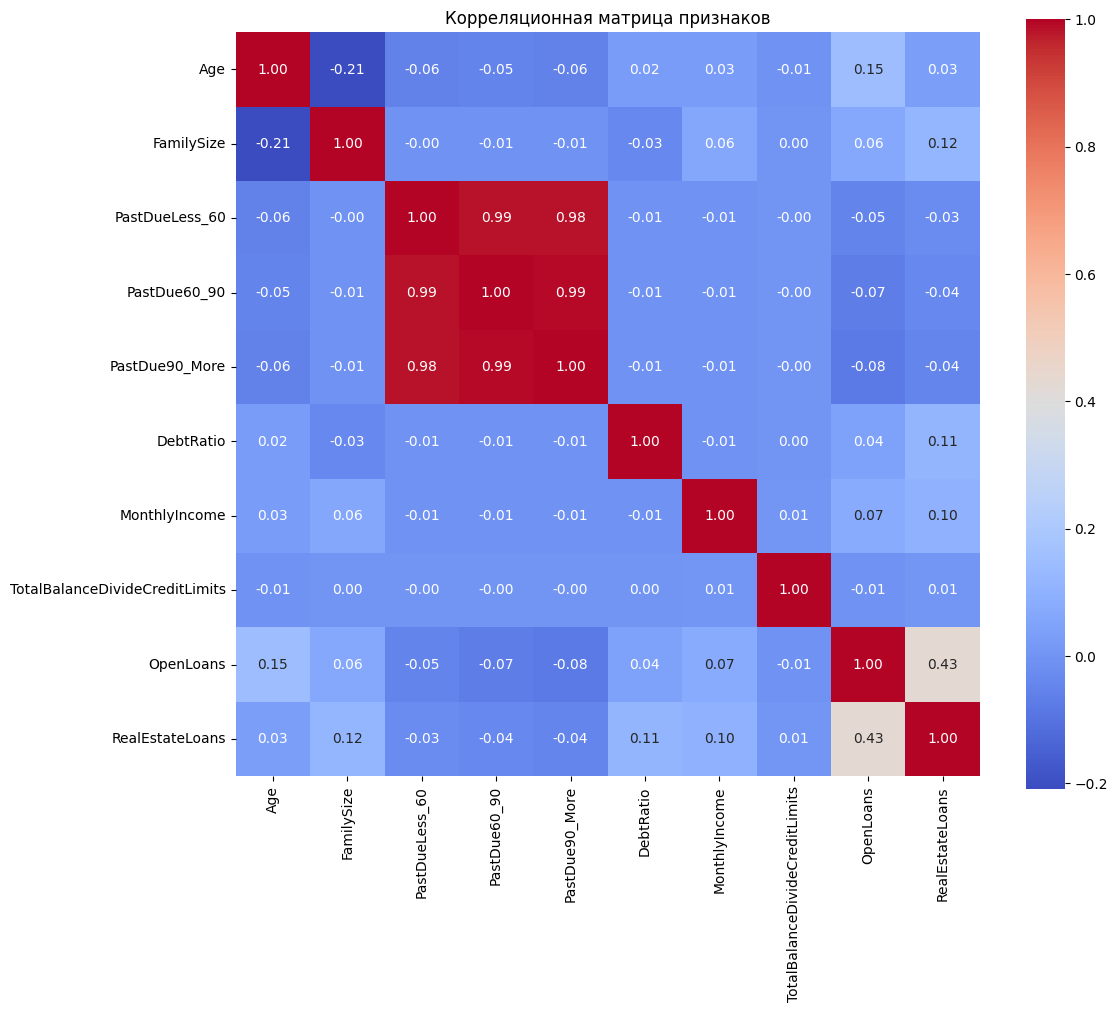

In [36]:
features_only = df_train.drop(columns=['Target'])
numeric_features = features_only.select_dtypes(include=[np.number])

# Строим корреляционную матрицу
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Корреляционная матрица признаков')
plt.show()


p < 0.05 → статистически значимая разница между группами => признак важен (возможно, с нелинейной связью).

p ≥ 0.05 → признак, скорее всего, не влияет на Target.

P-values по результатам ANOVA:

PastDueLess_60                     0.000000e+00
PastDue90_More                     0.000000e+00
Age                               1.032677e-293
PastDue60_90                      9.401356e-255
FamilySize                         2.248912e-49
OpenLoans                          4.036400e-20
MonthlyIncome                      2.170154e-07
RealEstateLoans                    1.468966e-03
DebtRatio                          2.429825e-02
TotalBalanceDivideCreditLimits     4.100912e-01
dtype: float64


<ipython-input-37-55aebd9d604c>:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




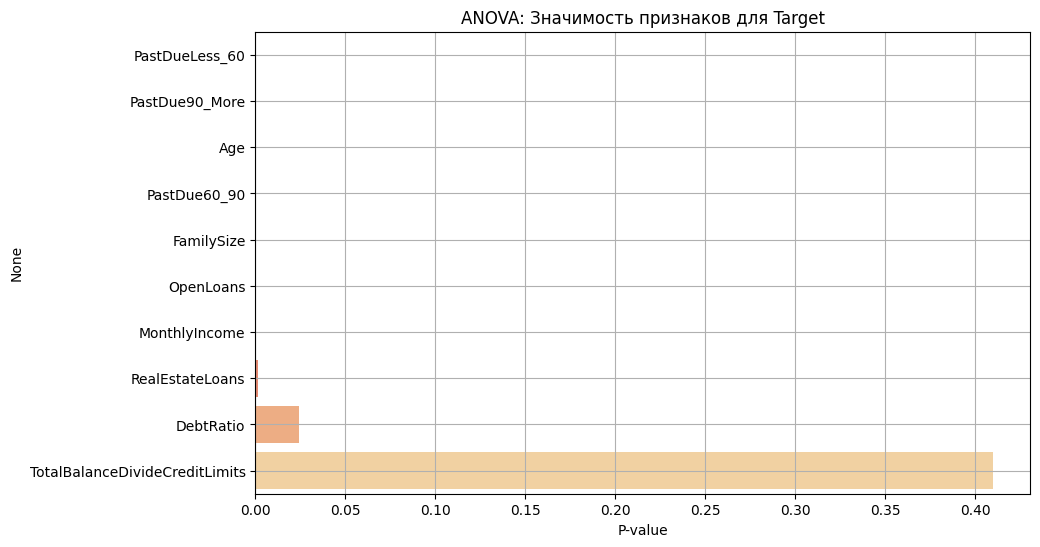

In [37]:
from scipy.stats import f_oneway

# Получаем список всех числовых признаков, кроме 'Target'
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.drop('Target')

anova_results = {}

# Проходим по каждому признаку
for col in numeric_cols:
    group_0 = df_train[df_train['Target'] == 0][col]
    group_1 = df_train[df_train['Target'] == 1][col]

    # ANOVA
    stat, p = f_oneway(group_0, group_1)
    anova_results[col] = p

# Сортируем по значимости
anova_sorted = pd.Series(anova_results).sort_values()


print("P-values по результатам ANOVA:\n")
print(anova_sorted)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=anova_sorted.values, y=anova_sorted.index, palette='magma')
plt.title('ANOVA: Значимость признаков для Target')
plt.xlabel('P-value')
plt.grid(True)
plt.show()


In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99694 entries, 0 to 100000
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Age                             99694 non-null  int64   
 1   FamilySize                      99694 non-null  float64 
 2   PastDueLess_60                  99694 non-null  int64   
 3   PastDue60_90                    99694 non-null  int64   
 4   PastDue90_More                  99694 non-null  int64   
 5   DebtRatio                       99694 non-null  float64 
 6   MonthlyIncome                   99694 non-null  float64 
 7   TotalBalanceDivideCreditLimits  99694 non-null  float64 
 8   OpenLoans                       99694 non-null  int64   
 9   RealEstateLoans                 99694 non-null  int64   
 10  Target                          99694 non-null  int64   
 11  age_group                       99694 non-null  category
 12  income_group          

Используем логистическую регрессию для оперделения важности признаков

<ipython-input-39-a1191f00d5cc>:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




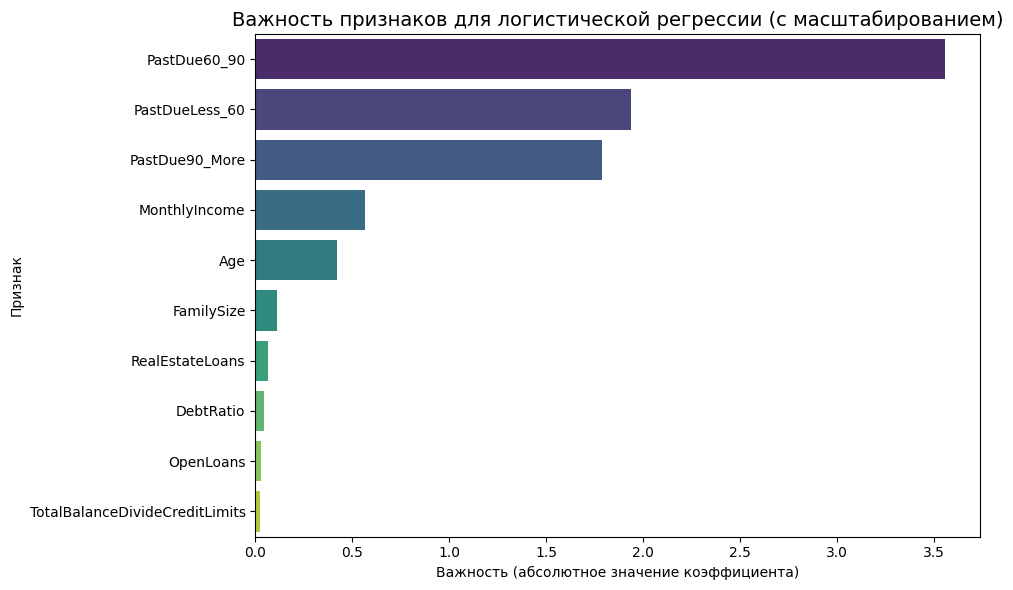

In [39]:
X = df_train.drop(['Target', 'age_group', 'income_group'],  axis=1)
y = df_train['Target']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучение модели логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(model.coef_[0])
}).sort_values('Importance', ascending=False)

# Построение графика
plt.figure(figsize=(10,6))
sns.barplot(data=importance, x='Importance', y='Feature', palette='viridis')
plt.title('Важность признаков для логистической регрессии (с масштабированием)', fontsize=14)
plt.xlabel('Важность (абсолютное значение коэффициента)')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# Задание 4

Уберем выбросы для Age, FamilySize, OpenLoans

In [40]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Флаг выброса
    df[f'{column}_outlier'] = ((df[column] < lower) | (df[column] > upper)).astype(int)

    # Отфильтрованные значения
    df = df[(df[column] >= lower) & (df[column] <= upper)]
    return df

# Применим для всех нужных признаков
for col in ['Age', 'FamilySize', 'OpenLoans', 'MonthlyIncome']:
    df_train = remove_outliers_iqr(df_train, col)


<ipython-input-40-001a6fba6f33>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
print("Размер данных после удаления выбросов:", df_train.shape)
df_train[['Age_outlier', 'FamilySize_outlier', 'OpenLoans_outlier', 'MonthlyIncome_outlier']].sum()


Размер данных после удаления выбросов: (83566, 17)


,0
Age_outlier,0
FamilySize_outlier,0
OpenLoans_outlier,0
MonthlyIncome_outlier,0


In [42]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Выбираем числовые признаки для "похожести"
knn_features = ['Age', 'MonthlyIncome', 'DebtRatio', 'OpenLoans', 'FamilySize']
X_knn = df_train[knn_features].copy()

# Масштабируем
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_knn)

# Создаем модель KNN
k_neighbors = 5
knn_model = NearestNeighbors(n_neighbors=k_neighbors + 1)  # +1, т.к. ближайший сосед — это сама точка
knn_model.fit(X_scaled)

# Находим индексы ближайших соседей
distances, indices = knn_model.kneighbors(X_scaled)

# Среднее расстояние до соседей — новый признак
df_train['KNN_AvgDistance'] = distances[:, 1:].mean(axis=1)  # исключаем дистанцию до себя

In [43]:
df_train.drop(columns= ['Age_outlier','FamilySize_outlier','OpenLoans_outlier'], inplace = True)

In [44]:
df_train['TotalPastDue'] = df_train['PastDueLess_60'] + df_train['PastDue90_More'] + df_train['PastDue60_90']

In [45]:
df_train.drop(columns= ['PastDueLess_60','PastDue90_More','PastDue60_90','MonthlyIncome_outlier'], inplace = True)

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83566 entries, 0 to 100000
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Age                             83566 non-null  int64   
 1   FamilySize                      83566 non-null  float64 
 2   DebtRatio                       83566 non-null  float64 
 3   MonthlyIncome                   83566 non-null  float64 
 4   TotalBalanceDivideCreditLimits  83566 non-null  float64 
 5   OpenLoans                       83566 non-null  int64   
 6   RealEstateLoans                 83566 non-null  int64   
 7   Target                          83566 non-null  int64   
 8   age_group                       83566 non-null  category
 9   income_group                    82616 non-null  category
 10  KNN_AvgDistance                 83566 non-null  float64 
 11  TotalPastDue                    83566 non-null  int64   
dtypes: category(2), float6

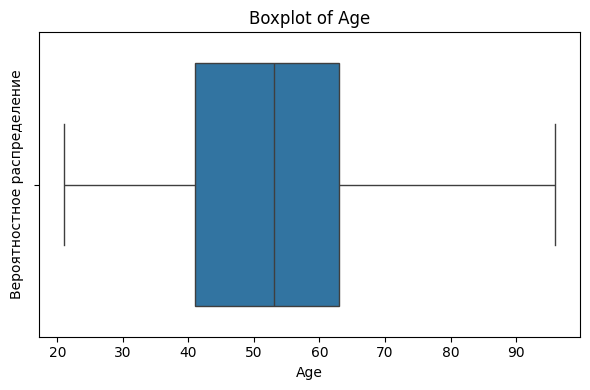

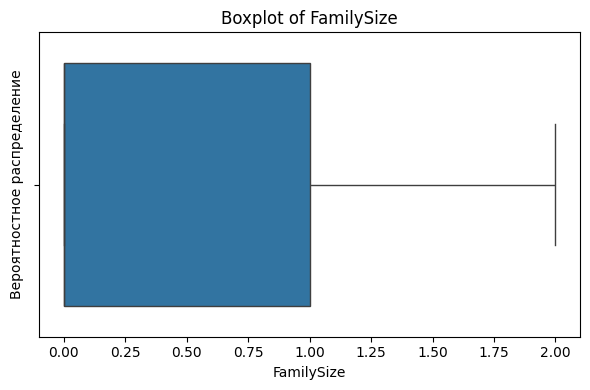

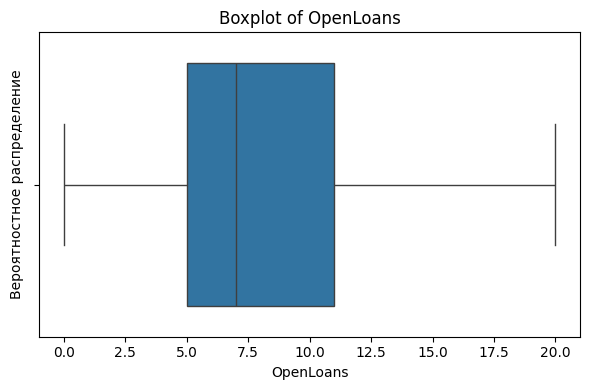

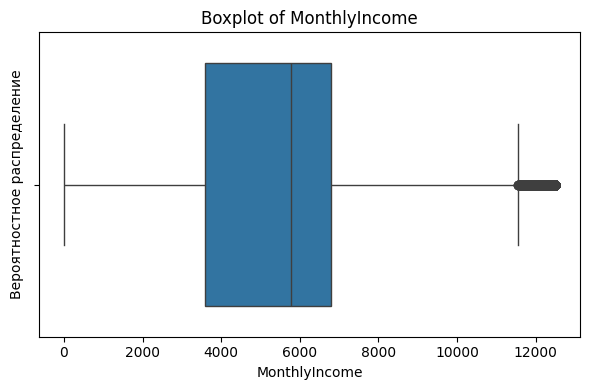

In [47]:
# Boxplot
numerical_columns = ['Age', 'FamilySize', 'OpenLoans','MonthlyIncome']

for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_train, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Вероятностное распределение')
    plt.tight_layout()
    plt.show()

Как видим выбросы были удалены

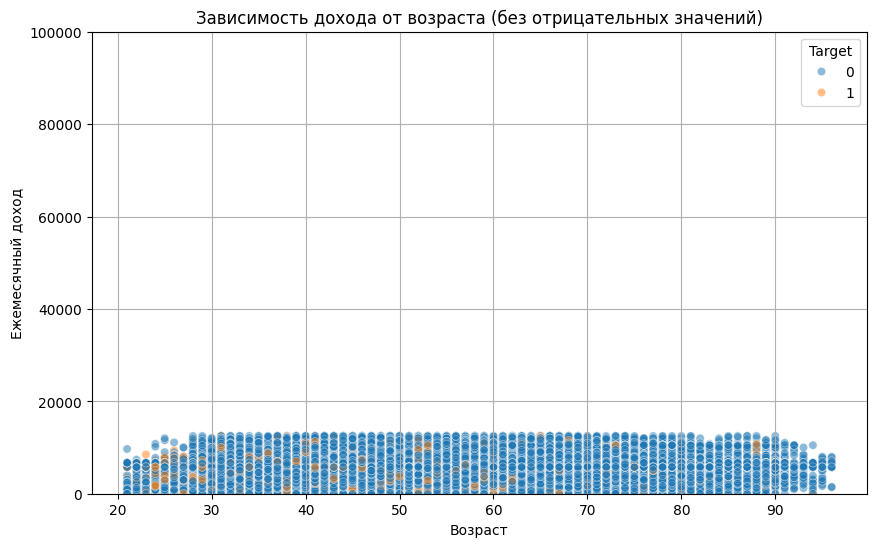

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='Age', y='MonthlyIncome', hue='Target', alpha=0.5)
plt.title('Зависимость дохода от возраста (без отрицательных значений)')
plt.xlabel('Возраст')
plt.ylabel('Ежемесячный доход')
plt.ylim(0, 100000)  # Ограничиваем y до разумного диапазона
plt.legend(title='Target')
plt.grid(True)
plt.show()

Настроили масштаб и по распределению видно, что до возраста ~50 доходы увеличиваются, а затем идет на спад

<ipython-input-49-4813b410c00e>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




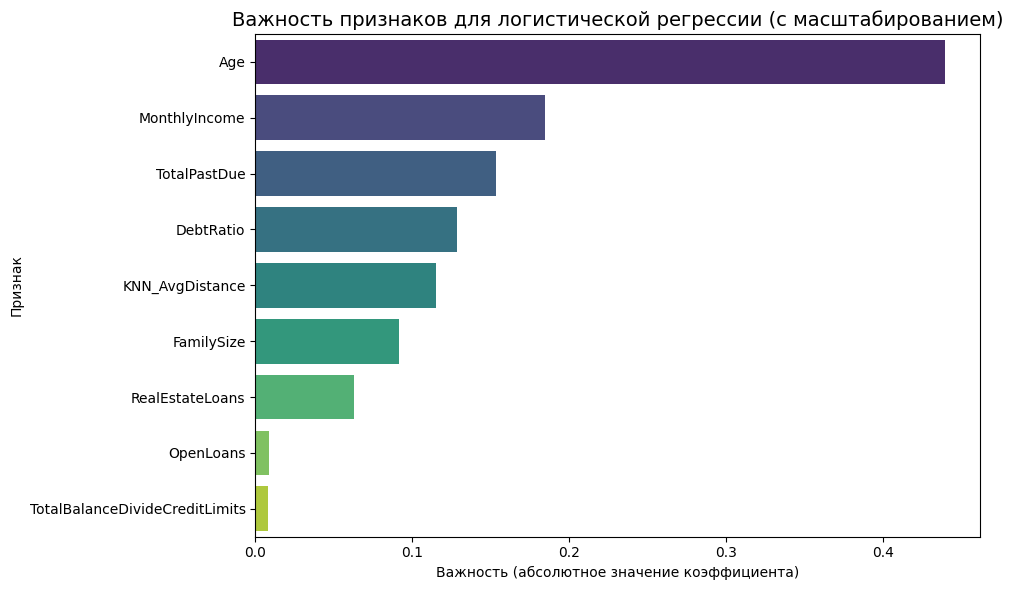

In [49]:
from sklearn.linear_model import LogisticRegression

# Загрузка данных (предполагается, что df_train уже существует)
X = df_train.drop(['Target', 'age_group', 'income_group'],  axis=1)
y = df_train['Target']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучение модели логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

# Создание DataFrame с важностью признаков
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(model.coef_[0])  # Берем абсолютные значения коэффициентов
}).sort_values('Importance', ascending=False)

# Построение графика
plt.figure(figsize=(10,6))
sns.barplot(data=importance, x='Importance', y='Feature', palette='viridis')
plt.title('Важность признаков для логистической регрессии (с масштабированием)', fontsize=14)
plt.xlabel('Важность (абсолютное значение коэффициента)')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# Задание 5

In [50]:
df_train.drop(columns = ['age_group','income_group'], inplace=True)

In [58]:
# Разделим исходные данные
X = df_train.drop(['Target'], axis=1)
y = df_train['Target']

# Обычные масштабированные признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Логарифмируем чувствительные признаки
X_log = X.copy()
for col in ['MonthlyIncome', 'DebtRatio', 'TotalPastDue']:
    X_log[col] = np.log1p(X_log[col])  # log(1 + x)

X_log_scaled = scaler.fit_transform(X_log)
X_log_scaled_df = pd.DataFrame(X_log_scaled, columns=X.columns)

# Датасет с удалением незначительных признаков
X_ = df_train.drop(['Target', 'TotalBalanceDivideCreditLimits', 'OpenLoans'], axis = 1)
y_ = df_train['Target']

# Делим на трейн/тест
X_trainS, X_testS, y_trainS, y_testS = train_test_split(X_scaled_df, y, test_size=0.25, random_state=42, stratify=y)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_scaled_df, y, test_size=0.25, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Задание 6 и 9

## Логистическая регрессия

In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr,
                       scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)
grid_lr.fit(X_trainS, y_trainS)

print("Лучшая модель:", grid_lr.best_estimator_)
print("Лучший AUC:", grid_lr.best_score_)

In [ ]:
y_pred = grid_lr.predict(X_testS)
print(classification_report(y_testS,y_pred))

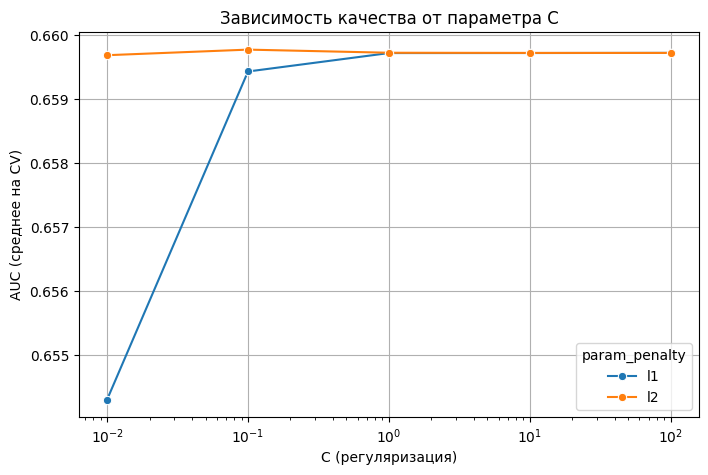

In [ ]:
results = pd.DataFrame(grid_lr.cv_results_)
plt.figure(figsize=(8,5))
sns.lineplot(x='param_C', y='mean_test_score', hue='param_penalty', data=results, marker='o')
plt.xscale('log')
plt.xlabel('C (регуляризация)')
plt.ylabel('AUC (среднее на CV)')
plt.title('Зависимость качества от параметра C')
plt.grid(True)
plt.show()


## KNN на масштаб. данных

In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn,
                        scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)
grid_knn.fit(X_trainS, y_trainS)

print("KNN на масштабированных данных")
print("Лучшая модель:", grid_knn.best_estimator_)
print("Лучший AUC:", grid_knn.best_score_)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [ ]:
y_pred2 = grid_knn.predict(X_testS)
print(classification_report(y_testS,y_pred2))

In [ ]:
# График
results_knn = pd.DataFrame(grid_knn.cv_results_)
plt.figure(figsize=(8,5))
sns.lineplot(x='param_n_neighbors', y='mean_test_score', hue='param_weights', data=results_knn, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('AUC (среднее на CV)')
plt.title('KNN: AUC от количества соседей')
plt.grid(True)
plt.tight_layout()
plt.show()

## KNN на линеризованных данных

In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_knn2 = GridSearchCV(KNeighborsClassifier(), param_grid_knn,
                        scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)
grid_knn2.fit(X_train_log, y_train_log)

print("KNN на линеризованных данных")
print("Лучшая модель:", grid_knn2.best_estimator_)
print("Лучший AUC:", grid_knn2.best_score_)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [ ]:
y_pred3 = grid_knn2.predict(X_testS)
print(classification_report(y_testS,y_pred3))

In [ ]:
results_knn = pd.DataFrame(grid_knn2.cv_results_)
plt.figure(figsize=(8,5))
sns.lineplot(x='param_n_neighbors', y='mean_test_score', hue='param_weights', data=results_knn, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('AUC (среднее на CV)')
plt.title('KNN: AUC от количества соседей')
plt.grid(True)
plt.tight_layout()
plt.show()

## SVM

In [ ]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
grid_svc = GridSearchCV(SVC(probability=True), param_grid_svc,
                        scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)
grid_svc.fit(X_trainS, y_trainS)

print("SVM")
print("Лучшая модель:", grid_svc.best_estimator_)
print("Лучший AUC:", grid_svc.best_score_)

KeyboardInterrupt: 

In [ ]:
y_pred4 = grid_svc.predict(X_testS)
print(classification_report(y_testS,y_pred4))

In [ ]:
results_svc = pd.DataFrame(grid_svc.cv_results_)
plt.figure(figsize=(8,5))
sns.lineplot(x='param_C', y='mean_test_score', hue='param_kernel', data=results_svc, marker='o')
plt.xlabel('C')
plt.ylabel('AUC (среднее на CV)')
plt.title('SVC: AUC от параметра C')
plt.grid(True)
plt.tight_layout()
plt.show()

## SGDClassifier

In [ ]:
param_grid_sgd = {
    'alpha': [1e-4, 1e-3, 1e-2],
    'penalty': ['l2', 'l1'],
    'loss': ['log_loss', 'modified_huber']
}

grid_sgd = GridSearchCV(SGDClassifier(max_iter=1000), param_grid_sgd,
                        scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)
grid_sgd.fit(X_trainS, y_trainS)

print("SGDClassifier")
print("Лучшая модель:", grid_sgd.best_estimator_)
print("Лучший AUC:", grid_sgd.best_score_)

In [ ]:
y_pred5 = grid_sgd.predict(X_testS)
print(classification_report(y_testS,y_pred5))

In [ ]:
results_sgd = pd.DataFrame(grid_sgd.cv_results_)
plt.figure(figsize=(8,5))
sns.lineplot(x='param_alpha', y='mean_test_score', hue='param_penalty', data=results_sgd, marker='o')
plt.xscale('log')
plt.xlabel('alpha (параметр регуляризации)')
plt.ylabel('AUC (среднее на CV)')
plt.title('SGDClassifier: AUC от alpha')
plt.grid(True)
plt.tight_layout()
plt.show()

## RandomForest

📌 Random Forest
Лучшая модель: RandomForestClassifier(max_depth=10, n_estimators=200)
Лучший AUC: 0.8603354113991893
F1-score: 0.22389791183294663


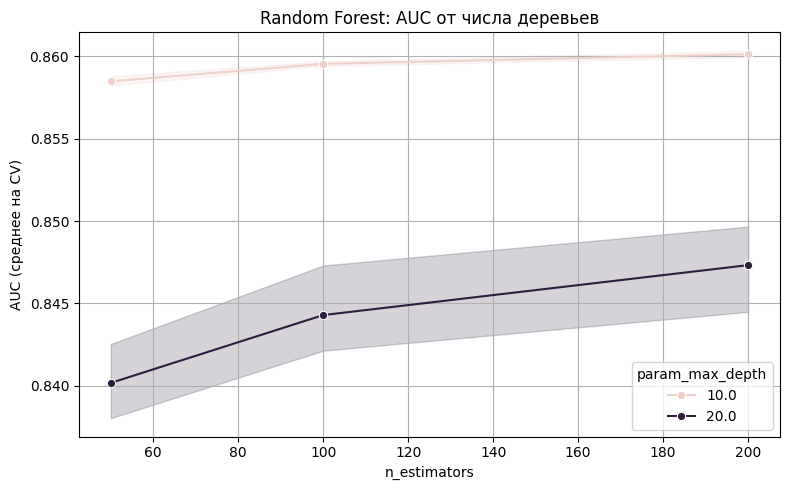

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf,
                       scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)
grid_rf.fit(X_train, y_train)

print("Random Forest")
print("Лучшая модель:", grid_rf.best_estimator_)
print("Лучший AUC:", grid_rf.best_score_)

In [ ]:
y_pred6 = grid_rf.predict(X_test)
print(classification_report(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.52      1.00      0.69     16446
           1       0.97      0.11      0.19     16630

    accuracy                           0.55     33076
   macro avg       0.75      0.55      0.44     33076
weighted avg       0.75      0.55      0.44     33076



In [ ]:
results_rf = pd.DataFrame(grid_rf.cv_results_)
plt.figure(figsize=(8,5))
sns.lineplot(x='param_n_estimators', y='mean_test_score', hue='param_max_depth', data=results_rf, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('AUC (среднее на CV)')
plt.title('Random Forest: AUC от числа деревьев')
plt.grid(True)
plt.tight_layout()
plt.show()

## Градиентный бустинг

In [ ]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb,
                        scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)
grid_xgb.fit(X_train, y_train)

print("XGBoost")
print("Лучшая модель:", grid_xgb.best_estimator_)
print("Лучший AUC:", grid_xgb.best_score_)

In [ ]:
y_pred7 = grid_xgb.predict(X_test)
print(classification_report(y_test,y_pred7))

In [ ]:
results_xgb = pd.DataFrame(grid_xgb.cv_results_)
plt.figure(figsize=(8,5))
sns.lineplot(x='param_n_estimators', y='mean_test_score', hue='param_max_depth', data=results_xgb, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('AUC (среднее на CV)')
plt.title('XGBoost: AUC от числа деревьев')
plt.grid(True)
plt.tight_layout()
plt.show()

## Ансамбли моделей

In [ ]:
from sklearn.ensemble import VotingClassifier

best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_

ensemble = VotingClassifier(
    estimators=[('lr', best_lr), ('rf', best_rf), ('xgb', best_xgb)],
    voting='soft'
)
ensemble.fit(X_train, y_train)

In [ ]:
y_pred8 = ensemble.predict(X_test)
print(classification_report(y_test,y_pred8))

## Задание 7, 8 (Новый подбор моделей)

In [60]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled2, y_resampled2 = smote.fit_resample(X_, y_)

In [53]:
y_resampled.value_counts()

,count
Target,
0,78113
1,78113


In [61]:
y_resampled2.value_counts()

,count
Target,
0,78113
1,78113


X_train - обычные данные

X_train2 - сбланасированные данные

X_train3 - сбалансированные данные (удалены некоторые признаки)

X_train4 - обычные данные (удалены некоторые признаки)

In [54]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0, shuffle=True)

In [69]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_resampled2, y_resampled2, test_size=0.2, random_state=0, shuffle=True)

In [74]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_, y_, test_size=0.2, random_state=0, shuffle=True)

## Случайный лес

In [55]:
rf = RandomForestClassifier()

In [56]:
rf.fit(X_train2,y_train2)

RandomForestClassifier()

In [57]:
y_pred_rf = rf.predict(X_test2)
print(classification_report(y_test2,y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     15507
           1       0.91      0.92      0.92     15739

    accuracy                           0.92     31246
   macro avg       0.92      0.92      0.92     31246
weighted avg       0.92      0.92      0.92     31246



Укажем оптимальные параметры для модели полученные ранее; сблансированные данные

In [63]:
rf2 = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)

In [64]:
rf2.fit(X_train2,y_train2)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)

In [65]:
y_pred_rf2 = rf.predict(X_test2)
print(classification_report(y_test2,y_pred_rf2))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     15507
           1       0.91      0.92      0.92     15739

    accuracy                           0.92     31246
   macro avg       0.92      0.92      0.92     31246
weighted avg       0.92      0.92      0.92     31246



Попробуем на обычных данных

In [88]:
rf3 = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)

In [89]:
rf3.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)

In [90]:
y_pred_rf3 = rf3.predict(X_test)
print(classification_report(y_test, y_pred_rf3))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     19529
           1       0.54      0.14      0.22      1363

    accuracy                           0.94     20892
   macro avg       0.74      0.57      0.59     20892
weighted avg       0.92      0.94      0.92     20892



На сблансированных данных, где удалены некоторые признаки

In [75]:
rf4 = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)

In [76]:
rf4.fit(X_train3, y_train3)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)

In [84]:
y_pred_rf4 = rf4.predict(X_test3)
print(classification_report(y_test3, y_pred_rf4))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     15507
           1       0.85      0.82      0.84     15739

    accuracy                           0.84     31246
   macro avg       0.84      0.84      0.84     31246
weighted avg       0.84      0.84      0.84     31246



На обычных данных, где удалены некоторые признаки

In [85]:
rf5 = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)

In [86]:
rf5.fit(X_train4, y_train4)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)

In [87]:
y_pred_rf5 = rf4.predict(X_test4)
print(classification_report(y_test4, y_pred_rf5))

              precision    recall  f1-score   support

           0       0.97      0.86      0.92     15590
           1       0.26      0.66      0.37      1124

    accuracy                           0.85     16714
   macro avg       0.62      0.76      0.64     16714
weighted avg       0.92      0.85      0.88     16714



Итог для RF:

Сбалансированные данные: лучшая rf2

Несбалансированные данные: лучшая модель rf5

## XGB

Сбалансированные данные

In [91]:
xgb = XGBClassifier(n_estimators = 100, max_deth = 3, learning_rate = 0.1)

In [92]:
xgb.fit(X_train2,y_train2)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[18:13:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_deth" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_deth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [95]:
y_pred_xgb = xgb.predict(X_test2)
print(classification_report(y_test2,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     15507
           1       0.89      0.86      0.87     15739

    accuracy                           0.87     31246
   macro avg       0.87      0.87      0.87     31246
weighted avg       0.87      0.87      0.87     31246



Обычные данные (некоторые признаки удалены)

In [96]:
xgb2 = XGBClassifier(n_estimators = 100, max_deth = 3, learning_rate = 0.1)

In [97]:
xgb2.fit(X_train4,y_train4)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[18:15:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_deth" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_deth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [98]:
y_pred_xgb2 = xgb2.predict(X_test4)
print(classification_report(y_test4,y_pred_xgb2))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     15590
           1       0.50      0.15      0.23      1124

    accuracy                           0.93     16714
   macro avg       0.72      0.57      0.60     16714
weighted avg       0.91      0.93      0.92     16714



## KNN

Сбалансированные данные

In [99]:
KNNC=KNeighborsClassifier(n_neighbors=11, p=1)
KNNC.fit(X_train2,y_train2)

KNeighborsClassifier(n_neighbors=11, p=1)

In [100]:
y_pred_knnc = KNNC.predict(X_test2)
print (classification_report(y_test2, y_pred_knnc))

              precision    recall  f1-score   support

           0       0.93      0.76      0.83     15507
           1       0.80      0.94      0.86     15739

    accuracy                           0.85     31246
   macro avg       0.86      0.85      0.85     31246
weighted avg       0.86      0.85      0.85     31246



Обычные данные (некоторые признаки удалены)

In [101]:
KNNC2=KNeighborsClassifier(n_neighbors=11, p=1)
KNNC2.fit(X_train4,y_train4)

KNeighborsClassifier(n_neighbors=11, p=1)

In [102]:
y_pred_knnc2 = KNNC2.predict(X_test4)
print (classification_report(y_test4, y_pred_knnc2))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97     15590
           1       0.58      0.02      0.03      1124

    accuracy                           0.93     16714
   macro avg       0.75      0.51      0.50     16714
weighted avg       0.91      0.93      0.90     16714



## SGD

Сбалансированные данные

In [109]:
sgd = SGDClassifier(alpha=0.1, loss='modified_huber', max_iter=1000)
sgd.fit(X_train2, y_train2)

SGDClassifier(alpha=0.1, loss='modified_huber')

In [110]:
y_pred_sgd = sgd.predict(X_test2)
print(classification_report(y_test2, y_pred_sgd))

              precision    recall  f1-score   support

           0       0.51      0.96      0.67     15507
           1       0.73      0.11      0.19     15739

    accuracy                           0.53     31246
   macro avg       0.62      0.53      0.43     31246
weighted avg       0.62      0.53      0.43     31246



Обычные данные (некоторые признаки удалены)

In [111]:
sgd2 = SGDClassifier(alpha=0.1, loss='modified_huber', max_iter=1000)
sgd2.fit(X_train4, y_train4)

SGDClassifier(alpha=0.1, loss='modified_huber')

In [112]:
y_pred_sgd2 = sgd2.predict(X_test4)
print(classification_report(y_test4, y_pred_sgd2))

              precision    recall  f1-score   support

           0       0.96      0.05      0.10     15590
           1       0.07      0.97      0.13      1124

    accuracy                           0.11     16714
   macro avg       0.51      0.51      0.11     16714
weighted avg       0.90      0.11      0.10     16714



Масштабированные данные

In [113]:
sgd3 = SGDClassifier(alpha=0.1, loss='modified_huber', max_iter=1000)
sgd3.fit(X_trainS, y_trainS)

SGDClassifier(alpha=0.1, loss='modified_huber')

In [115]:
y_pred_sgd3 = sgd3.predict(X_testS)
print(classification_report(y_testS, y_pred_sgd3))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     19529
           1       0.61      0.02      0.03      1363

    accuracy                           0.94     20892
   macro avg       0.77      0.51      0.50     20892
weighted avg       0.91      0.94      0.91     20892



Итог (лучшие модели):

Сблансированные данные: rf2, xgb, KNNC

Обычные данные (некоторые признаки удалены): rf5, xgb2


## Ансамбли

Сбалансированные данные

In [118]:
ensemble_balanced = VotingClassifier(
    estimators=[
        ('RandomForest', rf2),
        ('XGBoost', xgb),
        ('KNN', KNNC)
    ],
    voting='soft'
)

ensemble_balanced.fit(X_train2, y_train2)




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[18:51:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_deth" } are not used.




VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=200)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types...
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_deth=3, max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('KNN',
                              KNeighborsClassifier(n_neighbors=11, p=1))],
                 voting='soft')

Метрика f1-score особо не поменялась

In [119]:
y_pred_ensemble_balanced = ensemble_balanced.predict(X_test2)
print("Ансамбль на сбалансированных данных")
print(classification_report(y_test2, y_pred_ensemble_balanced))

Ансамбль на сбалансированных данных
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     15507
           1       0.89      0.92      0.91     15739

    accuracy                           0.90     31246
   macro avg       0.90      0.90      0.90     31246
weighted avg       0.90      0.90      0.90     31246



Обычные (с удалением незначительных признаков)

In [120]:
ensemble_regular = VotingClassifier(
    estimators=[
        ('RandomForest', rf5),
        ('XGBoost', xgb2)
    ],
    voting='soft'
)

ensemble_regular.fit(X_train4, y_train4)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[18:52:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_deth" } are not used.




VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=200)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_deth=3, max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

Результат f1-score стал хуже у класса 1 по сравнению с rf5, потому что у XGB метрики хуже

In [121]:
y_pred_ensemble_regular = ensemble_regular.predict(X_test4)
print("Ансамбль на обычных данных")
print(classification_report(y_test4, y_pred_ensemble_regular))

Ансамбль на обычных данных
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     15590
           1       0.53      0.13      0.21      1124

    accuracy                           0.93     16714
   macro avg       0.74      0.56      0.59     16714
weighted avg       0.91      0.93      0.91     16714



## Обучение на всем датасете

In [127]:
df_test = pd.read_excel('test.xlsx')

In [128]:
print("Test data:", df_test.shape)

Test data: (19998, 10)


In [129]:
df_test

,Age,FamilySize,PastDueLess_60,PastDue60_90,PastDue90_More,DebtRatio,MonthlyIncome,TotalBalanceDivideCreditLimits,OpenLoans,RealEstateLoans
0,52,2.0,0,0,0,0.267946578,9583.0,0.001019,14,2
1,40,2.0,0,0,0,0.411934862,9333.0,0.163523,10,2
2,33,3.0,1,1,0,0.620985011,1400.0,1.011239,8,0
3,41,3.0,0,0,0,0.567520053,9100.0,0.476197,10,3
4,55,2.0,0,0,0,0.079565586,12982.0,0.247196,9,0
...,...,...,...,...,...,...,...,...,...,...
19993,58,0.0,0,0,0,93.0,NaN,0.165388,1,0
19994,50,3.0,0,0,0,3191.0,NaN,0.006685,11,2
19995,55,1.0,1,0,0,0.225253535,7000.0,0.482834,3,1
19996,54,2.0,0,0,0,0.311981648,11333.0,0.081970,19,1


In [173]:
df_test = pd.read_csv('test (2).csv')

In [174]:
df_test

,ID,Age,FamilySize,PastDueLess_60,PastDue60_90,PastDue90_More,DebtRatio,MonthlyIncome,TotalBalanceDivideCreditLimits,OpenLoans,RealEstateLoans
0,100001,52,2.0,0,0,0,0.267946578,9583.0,0.001019,14,2
1,100002,40,2.0,0,0,0,0.411934862,9333.0,0.163523,10,2
2,100003,33,3.0,1,1,0,0.620985011,1400.0,1.011239,8,0
3,100004,41,3.0,0,0,0,0.567520053,9100.0,0.476197,10,3
4,100005,55,2.0,0,0,0,0.079565586,12982.0,0.247196,9,0
...,...,...,...,...,...,...,...,...,...,...,...
19993,119994,58,0.0,0,0,0,93.0,NaN,0.165388,1,0
19994,119995,50,3.0,0,0,0,3191.0,NaN,0.006685,11,2
19995,119996,55,1.0,1,0,0,0.225253535,7000.0,0.482834,3,1
19996,119997,54,2.0,0,0,0,0.311981648,11333.0,0.081970,19,1


In [175]:
test_ids = df_test['ID']
df_test.drop(columns=['ID', 'Unnamed: 0'], inplace=True, errors='ignore')

imputer = KNNImputer(n_neighbors=5)
df_test[['MonthlyIncome', 'FamilySize']] = imputer.fit_transform(df_test[['MonthlyIncome', 'FamilySize']])
df_test['DebtRatio'] = pd.to_numeric(df_test['DebtRatio'], errors='coerce').fillna(0)

# Выбираем числовые признаки для "похожести"
knn_features = ['Age', 'MonthlyIncome', 'DebtRatio', 'OpenLoans', 'FamilySize']
X_knn = df_test[knn_features].copy()

# Масштабируем
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_knn)

# Создаем модель KNN
k_neighbors = 5
knn_model = NearestNeighbors(n_neighbors=k_neighbors + 1)
knn_model.fit(X_scaled)
distances, indices = knn_model.kneighbors(X_scaled)

# Среднее расстояние до соседей — новый признак
df_test['KNN_AvgDistance'] = distances[:, 1:].mean(axis=1)

df_test['TotalPastDue'] = df_test['PastDueLess_60'] + df_test['PastDue90_More'] + df_test['PastDue60_90']
df_test.drop(columns=['PastDueLess_60', 'PastDue90_More', 'PastDue60_90'], inplace = True)

#Обычные
test_regular = df_test.copy()

In [176]:
# Для варианта с удалением признаков
test_reduced = df_test.drop(['TotalBalanceDivideCreditLimits', 'OpenLoans'], axis=1)

In [177]:
# Ансамбль для сбалансированных данных
ensemble_balanced_final = VotingClassifier(
    estimators=[
        ('rf', rf2),
        ('xgb', xgb),
        ('knn', KNNC)
    ],
    voting='soft'
)
ensemble_balanced_final.fit(X_resampled, y_resampled)

# Ансамбль для обычных данных (без слабых признаков)
ensemble_regular_final = VotingClassifier(
    estimators=[
        ('rf', rf5),
        ('xgb', xgb2)
    ],
    voting='soft'
)
ensemble_regular_final.fit(X_, y_)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:55:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_deth" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:55:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_deth" } are not used.




VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=200)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_deth=3, max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [178]:
X_resampled

,Age,FamilySize,DebtRatio,MonthlyIncome,TotalBalanceDivideCreditLimits,OpenLoans,RealEstateLoans,KNN_AvgDistance,TotalPastDue
0,56,1.000000,0.060572,5315.000000,0.498037,9,0,0.060558,1
1,38,1.000000,0.176965,3333.000000,0.060600,5,0,0.045208,0
2,42,2.000000,0.412141,8433.000000,0.675398,8,1,0.070176,1
3,34,1.000000,0.341437,3660.000000,0.630550,10,0,0.110733,2
4,41,1.000000,1331.000000,0.000000,0.167522,5,1,0.248176,0
...,...,...,...,...,...,...,...,...,...
156221,45,2.000000,0.352444,2997.837388,0.990732,5,0,0.061887,3
156222,45,0.436955,0.225034,7030.436955,0.984706,6,1,0.063460,0
156223,80,0.000000,0.273422,6000.000000,0.409342,16,0,0.158466,0
156224,45,0.181737,0.591964,7000.000000,0.073869,8,2,0.021234,0


In [179]:
test_regular

,Age,FamilySize,DebtRatio,MonthlyIncome,TotalBalanceDivideCreditLimits,OpenLoans,RealEstateLoans,KNN_AvgDistance,TotalPastDue
0,52,2.0,0.267947,9583.0,0.001019,14,2,0.217478,0
1,40,2.0,0.411935,9333.0,0.163523,10,2,0.184521,0
2,33,3.0,0.620985,1400.0,1.011239,8,0,0.296301,2
3,41,3.0,0.567520,9100.0,0.476197,10,3,0.131226,0
4,55,2.0,0.079566,12982.0,0.247196,9,0,0.191686,0
...,...,...,...,...,...,...,...,...,...
19993,58,0.0,93.000000,3430.8,0.165388,1,0,0.084805,0
19994,50,3.0,3191.000000,5316.4,0.006685,11,2,0.496661,0
19995,55,1.0,0.225254,7000.0,0.482834,3,1,0.180958,1
19996,54,2.0,0.311982,11333.0,0.081970,19,1,0.372392,0


In [180]:
# Предсказания
y_pred_balanced = ensemble_balanced_final.predict(test_regular)

In [181]:
y_pred_regular = ensemble_regular_final.predict(test_reduced)

In [182]:
# Сбалансированная модель
submission_balanced = pd.DataFrame({'ID': test_ids, 'Target': y_pred_balanced})
submission_balanced.to_csv('submission_balanced.csv', index=False)

# Обычная модель
submission_regular = pd.DataFrame({'ID': test_ids, 'Target': y_pred_regular})
submission_regular.to_csv('submission_regular.csv', index=False)
